# Initial Analysis
This notebook contains the initial analysis and preprocessing of Wikispeedia graph. We perform the following tasks:
- We load the files
- We process the data to create the graph representation
- We perform an analysis over the paths, both succesful and failed
- We study the link structure and position through BeatifulSoup
- We present multiple statistical results

In [2]:
# Generally needed libraries

import pandas as pd
import networkx as nx
import numpy as np

import matplotlib.pyplot as plt


### Graph Analysis

In this section we start our basic analysis by creating a graph representation of the data and by running graph analytics and visualization functions.

In [3]:
# Loading the data, by skipping the first descriptive rows. Note that we could also use
# the parameter "comment=#" to dodge unecessary data.

articles = pd.read_table("data/graph/articles.tsv", skiprows=11, names=["article"])

categories = pd.read_csv(
    "data/graph/categories.tsv", skiprows=12, sep="\t", names=["article", "category"]
)

links = pd.read_csv(
    "data/graph/links.tsv", skiprows=11, sep="\t", names=["article1", "article2"]
)


In [4]:
# Creating the graph representation in a dataframe
wiki_graph = pd.DataFrame(columns=["article", "category", "outlinks", "outlinks_count", "inlinks_count"])

# Adding all articles. This could also be used as index.
wiki_graph["article"] = articles["article"]

wiki_graph["outlinks"] = [list() for x in range(len(wiki_graph.index))]
wiki_graph["inlinks_count"] = [0 for x in range(len(wiki_graph.index))]

# Add to each article entry its categories as a list
grouped_categories = categories.groupby("article")
for entry in grouped_categories:
    article_name = entry[0]
    cats_df = entry[1]["category"]
    cats_list = cats_df.values.tolist()

    indices = wiki_graph.index[wiki_graph["article"] == article_name].tolist()
    for i in indices:
        wiki_graph.at[i, "category"] = cats_list


# Add to each article entry its links as a list.
grouped_links = links.groupby("article1")
for entry in grouped_links:
    article_name = entry[0]
    links_df = entry[1]["article2"]
    links_list = links_df.values.tolist()

    # Add all links to article 1
    indices = wiki_graph.index[wiki_graph["article"] == article_name].tolist()
    for i in indices:
        previous_list = list(wiki_graph.at[i, "outlinks"])
        new_list = previous_list + links_list
        wiki_graph.at[i, "outlinks"] = new_list

    for link in links_list:
        article2 = link
        article2_index = wiki_graph.index[wiki_graph["article"] == article2].tolist()
        for i in article2_index:
            wiki_graph.at[i, "inlinks_count"] = wiki_graph.at[i, "inlinks_count"] + 1

# Add to each article how many links it has
wiki_graph["outlinks_count"] = wiki_graph["outlinks"].apply(lambda x: len(x))

# Some reality checks
assert wiki_graph.shape[0] == 4604
assert wiki_graph["article"].is_unique 
assert wiki_graph["article"].isnull().values.any() == False

# Filter our single nodes
wiki_graph = wiki_graph[(wiki_graph["outlinks_count"] > 0) | (wiki_graph["inlinks_count"] > 0)]

# Check output
wiki_graph.tail(5)


,article,category,outlinks,outlinks_count,inlinks_count
4599,Zionism,"[subject.People.Political_People, subject.Reli...","[18th_century, 19th_century, Adolf_Hitler, Alb...",74,25
4600,Zirconium,[subject.Science.Chemistry.Chemical_elements],"[Aluminium, Arabic_language, Australia, Bicycl...",42,15
4601,Zoroaster,[subject.People.Religious_figures_and_leaders],"[18th_century, 9th_century, Afghanistan, Age_o...",28,9
4602,Zuid-Gelders,"[subject.Geography.European_Geography, subject...","[Brabantian, Dutch_language, East_Flemish, Hol...",5,5
4603,Zulu,[subject.Geography.African_Geography],"[AK-47, Bantu, Cape_Town, Christianity, Englis...",15,14


In [5]:
# Validation and basic checks and graph statistics
print("Is articles unique in the dataframe?", wiki_graph["article"].is_unique)
print("How many articles are in the data?", len(wiki_graph))
print("Graph shape", wiki_graph.shape)

print()

print("Are there NULL values in articles?", wiki_graph["article"].isnull().values.any())
print(
    "Are there NULL values in categories?", wiki_graph["category"].isnull().values.any()
)



Is articles unique in the dataframe? True
How many articles are in the data? 4592
Graph shape (4592, 5)

Are there NULL values in articles? False
Are there NULL values in categories? True


In [6]:
# We proceed with some graph analytics and visualizations.
# Here, we provide some profound helper functions to generate graphs using networkX

def generate_nx_from_wiki(wiki_graph):
    """Generate a networkx graph from Wikispeedia graph dataframe.

    Args:
        wiki_graph (_type_): Wikispeedia graph dataframe

    Raises:
        ValueError: If it exists a link that has no other links

    Returns:
        _type_: A networkX graph Object
    """
    #G = nx.Graph()
    G = nx.DiGraph()
    sampled_wiki_graph = wiki_graph
    for ind in sampled_wiki_graph.index:
        node_name = wiki_graph["article"][ind]
        node_links = wiki_graph["outlinks"][ind]
        node_links_count = wiki_graph["outlinks_count"][ind]

        #if len(node_links) == 0:
        #    raise ValueError

        for l in node_links:
            G.add_edge(node_name, l)

    return G

import json 
def generate_json_graph(path, wiki_graph):
    data = {
        "nodes" : [],
        "links" : []
    }
    
    for ind in wiki_graph.index:
        node_name = wiki_graph["article"][ind]
        node_links = wiki_graph["outlinks"][ind]
        #node_links_count = wiki_graph["outlinks_count"][ind]

        new_node = {
          "id": ind,
          "name": node_name,
        }
        
        data["nodes"].append(new_node)
        
        for l in node_links:
            index = wiki_graph.index[wiki_graph["article"] == l].tolist()
            assert len(index) == 1
            inx_l = index[0]
            new_link = {
                "source": ind,
                "target": inx_l
            }
            
            data["links"].append(new_link) 

    with open(path, "w") as write_file:
        json.dump(data, write_file, indent=4)
        
    return

def graph_report(G):
    """Prints some graph analytics stuff about a graph

    Args:
        G (_type_): NetworkX graph
    """
    print("Total number of nodes: " + str(G.number_of_nodes()))
    print("Total number of edges: " + str(G.number_of_edges()))

In [7]:
# Checking the structure of the graph
G = generate_nx_from_wiki(wiki_graph)
graph_report(G)

Total number of nodes: 4592
Total number of edges: 119882


In [8]:
generate_json_graph("graph.json", wiki_graph)

In [9]:
# Graph Analytics: We use networkX functions to get insight about popular nodes of the graph.


def sort_dict_by_value(dict):
    """Sort a dictionary based on its va;ues

    Args:
        dict (_type_): Python dictionary

    Returns:
        _type_: A new instance of the dictionary sorted by value
    """
    return sorted(dict.items(), key=lambda x: x[1], reverse=True)


topN = 200

# Getting the top-N nodes with highest pagerank value
print(">> Top", topN, "Pagerank articles of wiki graph are:")
pagerankDict = nx.pagerank(G, alpha=0.9)
top_tuples = sort_dict_by_value(pagerankDict)[:topN]
pagerank_nodes = set()
for (key, value) in top_tuples:
    print(key, "->", value)
    pagerank_nodes.add(key)

print()

# Getting the top-N nodes with highest eigenvector centrality value
print(">> Top", topN, "eigenvector centrality articles of wiki graph are:")
bc_dict = nx.eigenvector_centrality(G)
top_tuples = sort_dict_by_value(bc_dict)[:topN]
eigen_nodes = set()
for (key, value) in top_tuples:
    print(key, "->", value)
    eigen_nodes.add(key)

print()

print(">> Top", topN, "Degree Centrality articles of wiki graph are:")
degreeDict = nx.degree_centrality(G)#nx.pagerank(G, alpha=0.9)
top_tuples = sort_dict_by_value(degreeDict)[:topN]
degree_nodes = set()
for (key, value) in top_tuples:
    print(key, "->", value)
    degree_nodes.add(key)


>> Top 200 Pagerank articles of wiki graph are:
United_States -> 0.00977324494244742
France -> 0.006823269799314179
Europe -> 0.006685270249889305
United_Kingdom -> 0.006516000824162603
English_language -> 0.005156375084213169
Germany -> 0.005125973207380523
World_War_II -> 0.004950326981162153
Latin -> 0.004682639237183847
England -> 0.004546831105899607
India -> 0.004328045220777949
Japan -> 0.004093543145074442
Italy -> 0.003961205921913621
Spain -> 0.003905071683382449
Time_zone -> 0.003819166904467246
China -> 0.0038048877032603166
Russia -> 0.0037391778255280016
Currency -> 0.0036069326570562195
Canada -> 0.0035350102647443535
Africa -> 0.003313619007430789
Australia -> 0.0032930562114677534
Christianity -> 0.0032860993924940488
List_of_countries_by_system_of_government -> 0.0031666761245762137
London -> 0.003096929229932251
United_Nations -> 0.0030653331983923606
Islam -> 0.0029930649026853134
French_language -> 0.002966328058755238
North_America -> 0.002761048904051675
World_Wa

In [10]:
hubs = degree_nodes.intersection(eigen_nodes).intersection(pagerank_nodes)
print(len(hubs))
hubs

114


{'16th_century',
 '18th_century',
 '19th_century',
 '20th_century',
 'Afghanistan',
 'Africa',
 'Agriculture',
 'Ancient_Greece',
 'Ancient_Rome',
 'Arabic_language',
 'Argentina',
 'Asia',
 'Atlantic_Ocean',
 'Australia',
 'Austria',
 'Belgium',
 'Brazil',
 'British_Empire',
 'Buddhism',
 'Byzantine_Empire',
 'California',
 'Canada',
 'Capital',
 'China',
 'Christianity',
 'Cold_War',
 'Communism',
 'Cuba',
 'Currency',
 'Democracy',
 'Denmark',
 'Earth',
 'Egypt',
 'England',
 'English_language',
 'Europe',
 'European_Union',
 'Finland',
 'Football_%28soccer%29',
 'France',
 'French_language',
 'German_language',
 'Germany',
 'Great_Britain',
 'Greece',
 'Hungary',
 'India',
 'Indian_Ocean',
 'Indonesia',
 'Iran',
 'Iraq',
 'Ireland',
 'Islam',
 'Israel',
 'Italy',
 'Japan',
 'Jew',
 'Judaism',
 'Latin',
 'Lebanon',
 'List_of_countries_by_system_of_government',
 'London',
 'Malaysia',
 'Mediterranean_Sea',
 'Mexico',
 'Middle_Ages',
 'Middle_East',
 'Morocco',
 'Moscow',
 'NATO',
 'N

In [12]:
# Link count visualization

links_counts = wiki_graph["links_count"].values

plt.hist(links_counts, bins=100)
plt.title("Histogram of total number of links per article")
plt.xlabel("Number of Links")
plt.ylabel("Number of Articles")
plt.show()

KeyError: 'links_count'

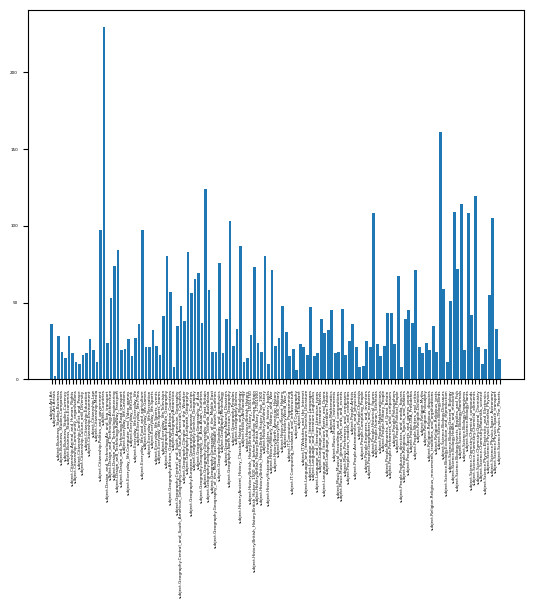

Top 5 categories:


,article
category,
subject.Countries,229
subject.Science.Biology.Birds,161
subject.Geography.Geography_of_Great_Britain,124
subject.Science.Chemistry.Chemical_elements,119
subject.Science.Biology.Mammals,114


In [ ]:
# Categories visualization
groups = categories.groupby("category").count()

labels = list(groups.index)
values = list(groups["article"])
X_axis = np.arange(len(labels))

plt.rcParams["font.size"] = "3"

plt.xticks(rotation=90)
plt.bar(labels, values)
plt.show()

# Highest values of our categories
groups = categories.groupby("category").count()
values = list(groups["article"])
highest_cat = groups.sort_values(ascending=False, by=["article"])

print("Top 5 categories:")
highest_cat.head(5)


### Path analysis

In this section we show our analysis over the paths of wikispeedia.

In [12]:
# Initialize some helper functions


def quantize_path(str_path):
    return str_path.split(";")


def get_start_node(list_path):
    return list_path[0]


def get_target_node(list_path):
    return list_path[len(list_path) - 1]


def count_backtracks(list_path):
    return list_path.count("<")


In [13]:
# Loading the finisged path data and processing with the helper functions

paths_finished = pd.read_csv(
    "data/graph/paths_finished.tsv",
    skiprows=15,
    sep="\t",
    names=[
        "hashedIpAddress",
        "timestamp",
        "durationInSec",
        "path",
        "rating",
        # "status",
        "start",
        "target",
    ],
)

# Not needed columns
# paths_finished["status"] = ["Success" for x in range(len(paths_finished.index))]

# Processing and parsing the paths
paths_finished["path"] = paths_finished["path"].apply(quantize_path)
paths_finished["start"] = paths_finished["path"].apply(get_start_node)
paths_finished["target"] = paths_finished["path"].apply(get_target_node)
paths_finished["backtracks"] = paths_finished["path"].apply(count_backtracks)

# Dropping some columns that we will not use
paths_finished = paths_finished.drop(columns=["hashedIpAddress", "timestamp"])

# Check
paths_finished.tail(10)


,durationInSec,path,rating,start,target,backtracks
51308,40,"[Women%27s_rights, Suffrage, Politics, Communism]",NaN,Women%27s_rights,Communism,0
51309,136,"[Women%27s_rights, Human_rights, Communism, Ma...",1.0,Women%27s_rights,Chinese_language,0
51310,117,"[Women%27s_rights, Property, Clothing, Weather...",5.0,Women%27s_rights,Autumn,0
51311,418,"[Work_%28thermodynamics%29, Energy, Aristotle,...",3.0,Work_%28thermodynamics%29,Film,0
51312,133,"[Work_%28thermodynamics%29, Cambridge, City_st...",3.0,Work_%28thermodynamics%29,Pyongyang,1
51313,66,"[Yagan, Ancient_Egypt, Civilization]",NaN,Yagan,Civilization,0
51314,165,"[Yagan, Folklore, Brothers_Grimm, <, 19th_cent...",3.0,Yagan,Fiction,1
51315,228,"[Yagan, Australia, England, France, United_Sta...",NaN,Yagan,U.S._Open_%28tennis%29,0
51316,56,"[Yarralumla%2C_Australian_Capital_Territory, A...",1.0,Yarralumla%2C_Australian_Capital_Territory,Abraham_Lincoln,0
51317,30,"[Ziad_Jarrah, Germany, Jew]",NaN,Ziad_Jarrah,Jew,0


In [14]:
# Loading the unfinished paths, just like the previous one

paths_unfinished = pd.read_csv(
    "data/graph/paths_unfinished.tsv",
    skiprows=19,
    sep="\t",
    names=["hashedIpAddress", "timestamp", "durationInSec", "path", "target", "type"],
)

paths_unfinished = paths_unfinished.drop(columns=["hashedIpAddress", "timestamp"])

paths_unfinished["path"] = paths_unfinished["path"].apply(quantize_path)
paths_unfinished["start"] = paths_unfinished["path"].apply(get_start_node)
paths_unfinished["backtracks"] = paths_unfinished["path"].apply(count_backtracks)

# Dropping the timeouts, as we dont know if this fail is due to user being idle or fail to reach
# the final target article.
paths_unfinished = paths_unfinished[paths_unfinished["type"] != "timeout"]

# Check
paths_unfinished.head(10)


,durationInSec,path,target,type,start,backtracks
1,49,[Paraguay],Mount_St._Helens,restart,Paraguay,0
5,175,"[4-2-0, United_States, Agriculture, Sugar, Aus...",Cane_Toad,restart,4-2-0,0
6,19,[Logic],Moon_landing,restart,Logic,0
9,8,[Niobium],Beeching_Axe,restart,Niobium,0
10,334,"[Saint_Kitts_and_Nevis, United_Kingdom, World_...",Sandy_Koufax,restart,Saint_Kitts_and_Nevis,0
12,403,"[Symmetry, Science, Age_of_Enlightenment, Dark...",Scottish_Episcopal_Church,restart,Symmetry,0
13,22,[Prostate_cancer],Du_Fu,restart,Prostate_cancer,0
14,115,"[Tasmanian_Devil, Dog, Postage_stamp, Wood]",Love,restart,Tasmanian_Devil,0
17,245,"[Tim_Berners-Lee, England, Atlantic_Ocean, Uni...",Volcanic_pipe,restart,Tim_Berners-Lee,0
18,13,[Snowball_Earth],Medal_of_Honor,restart,Snowball_Earth,0


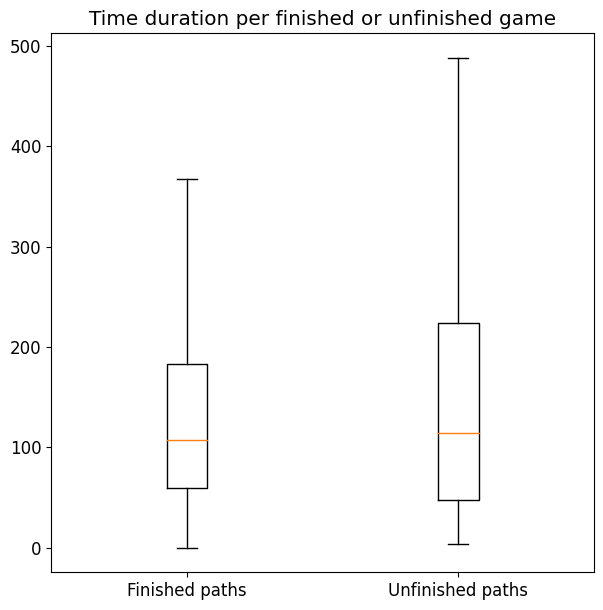

In [15]:
# Time duration analysis and plotting
duration_finish = paths_finished["durationInSec"].to_numpy()
duration_unfinish = paths_unfinished["durationInSec"].to_numpy()

duration = [duration_finish, duration_unfinish]

fig = plt.figure(figsize=(7, 7))
plt.rcParams["font.size"] = "12"

plt.boxplot(duration, showfliers=False, labels=["Finished paths", "Unfinished paths"])
plt.title("Time duration per finished or unfinished game")
plt.show()


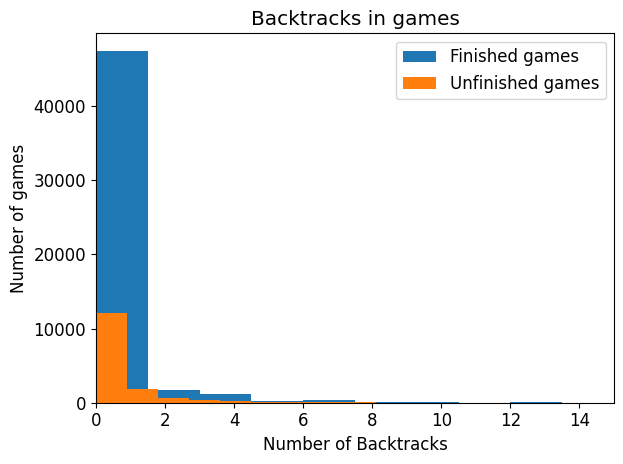

In [16]:
# Backtrack analysis and plotting

backtracks_finished = list(paths_finished["backtracks"])
backtracks_unfinished = list(paths_unfinished["backtracks"])


fig, (ax1) = plt.subplots(1, 1)

ax1.set_ylabel("Number of games")
ax1.set_xlabel("Number of Backtracks")
ax1.set_title("Backtracks in games")
ax1.hist(backtracks_finished, bins=30, label="Finished games")
ax1.hist(backtracks_unfinished, bins=30, label="Unfinished games")
ax1.set_xlim(0, 15)
ax1.legend()
fig.tight_layout()
plt.show()


### Link Position Analysis

In this section we present our preliminary analysis for the link position in the HTML pages.

For each article page, we scrape the html source code to retrieve the links and the paragraph number in which they are placed. Aso a label is stored with the label 'Lead' or 'Body'. The dictionary has the form:

{"page_name" : {"link_page_name_1" : ["paragraph_number_1","lead"] , "link_page_name_2" : "paragraph_number_2","body"}}

In [17]:
# Importing additional libraries needed for this analysis
import os
from bs4 import BeautifulSoup
import urllib.parse
from tqdm import tqdm

# This path is present locally in our machines, because the size is too big to upload it to the repo.
path = "./data/graph/wpcd"
page_pos_dict = dict()
pars = []

# This routine requires long time to run
for article_name in tqdm(wiki_graph["article"]):
    for root, dirs, files in os.walk(path):
        for name in files:
            if name == "{}.htm".format(article_name):
                try:
                    with open(os.path.join(root, name), encoding="utf-8") as file:
                        soup = BeautifulSoup(file, "lxml")
                    links_dict = dict()
                    par_len = [len(par.getText()) for par in soup.find_all("p")]
                    if 1 in par_len and 0 in par_len:
                        index = min(par_len.index(0), par_len.index(1))
                    elif 1 in par_len:
                        index = par_len.index(1)
                    elif 0 in par_len:
                        index = par_len.index(0)
                    else:
                        index = len(par_len)
                    for i, p in enumerate(soup.find_all("p")):
                        for link in p.find_all("a"):
                            link_title = link.get("title")
                            if (
                                link_title != None
                                and link_title != ""
                                and "jpg" not in link_title
                                and "png" not in link_title
                            ):
                                if (
                                    urllib.parse.quote(link_title.replace(" ", "_"))
                                    not in links_dict.keys()
                                ):
                                    links_dict[
                                        urllib.parse.quote(link_title.replace(" ", "_"))
                                    ] = (i, "lead" if i < index else "body")


                    if soup.find_all('table', class_="infobox"):
                        infobox = soup.find_all('table', class_="infobox")[0]
                        for link in infobox.findAll('a'):
                        # for link in infobox:
                            if 'png' not in link['href'] and "jpg" not in link['href']:
                                info_link_title = link.get("title")
                                if (urllib.parse.quote(info_link_title.replace(" ", "_")) not in links_dict.keys()) and info_link_title!= "" and info_link_title!= "_":
                                    links_dict[
                                        urllib.parse.quote(info_link_title.replace(" ", "_"))
                                    ] = (None,'infobox')

                    page_pos_dict[article_name] = links_dict      
                except Exception:
                    # A small number of articles throw an exception on parsing, we skip them.
                    # pass
                    #print(Exception)
                    #print(
                    ##   os.path.join(root, name)
                    #)  # 5 pages cause an exception, because html cannot be decoded
                    pass

100%|██████████| 4589/4589 [05:41<00:00, 13.44it/s]


In [20]:
# Saving our results as json to be able to load them without re-running the cell above
# import json

# with open("page_pos_dict.json", "w") as outfile:
#     json.dump(page_pos_dict, outfile)


In [13]:
# Uncomment the following cell to load the results from the dictionary.
import json
with open("page_pos_dict.json", "r") as file:
   page_pos_dict = json.load(file)


In [14]:
page_pos_dict_mod = {'page_name': [], 'linked_page': [], 'link_position':[], 'link_par' : []}
for page in page_pos_dict.keys():
    for link in page_pos_dict[page].keys():
        link_par,link_pos = page_pos_dict[page][link]
        page_pos_dict_mod['page_name'].append(page)
        page_pos_dict_mod['linked_page'].append(link)
        page_pos_dict_mod['link_position'].append(link_pos)
        page_pos_dict_mod['link_par'].append(link_par)

In [57]:
link_pos_df = pd.DataFrame.from_dict(page_pos_dict_mod)
print(link_pos_df.head(5))
print(link_pos_df.shape)

                          page_name     linked_page link_position  link_par
0  %C3%81ed%C3%A1n_mac_Gabr%C3%A1in  D%C3%A1l_Riata          lead         0
1  %C3%81ed%C3%A1n_mac_Gabr%C3%A1in         Kingdom          lead         0
2  %C3%81ed%C3%A1n_mac_Gabr%C3%A1in        Scotland          lead         0
3  %C3%81ed%C3%A1n_mac_Gabr%C3%A1in         Ireland          lead         0
4  %C3%81ed%C3%A1n_mac_Gabr%C3%A1in         Columba          lead         0
(99128, 4)


In [16]:
# Procuding statistics about the position of the links in the HTML pages.
counter = [0 for i in range(400)]
classes = [0, 0]
for key in page_pos_dict.keys():
    for link in page_pos_dict[key]:
        counter[page_pos_dict[key][link][0]] += 1
        if page_pos_dict[key][link][1] == "lead":
            classes[0] += 1
        else:
            classes[1] += 1

total_links = sum(counter)
lead_links_p = round((np.array(classes) / total_links * 100)[0])
body_links_p = round((np.array(classes) / total_links * 100)[1])

print(
    "Out of total",
    total_links,
    "links,",
    lead_links_p,
    "% are in the lead section, while",
    body_links_p,
    "% are in the body section",
)


Out of total 99128 links, 21 % are in the lead section, while 79 % are in the body section


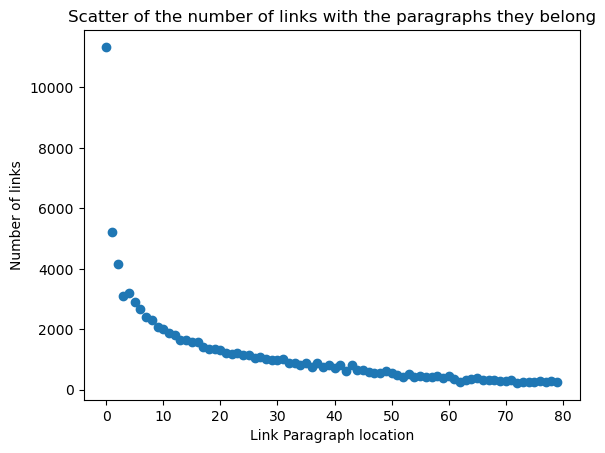

In [17]:
# Plotting the number of links vs their corresponding paragraph
plt.scatter([i for i in range(80)], counter[0:80])
plt.ylabel("Number of links")
plt.xlabel("Link Paragraph location")
plt.title("Scatter of the number of links with the paragraphs they belong")
plt.rcParams["font.size"] = "12"

plt.show()


In [18]:
# Analysis of links in wikispeedia games
finished_paths = pd.read_csv(
    "./data/graph/paths_finished.tsv", sep="\t", skiprows=16, header=None
)

# Parse and store the paths removing back tracks (<).
paths = []
for path in finished_paths[3]:
    if "<" not in path:
        path = path.split(";")
        paths.append(path)


In [19]:
len(paths)

42323

In [20]:
# For each click of the players, we store the paragraph number of
# the chosen link and the average paragraph number of all the links in the page
chosen_pars = []
avg_pars = []
chosen_labels = []
for path in paths:
    for i, article in enumerate(path):
        if i < len(path) - 1:
            source = article
            target = path[i + 1]
            if (
                target in page_pos_dict[source].keys()
            ):  # some links are missing from the dictionary, around 10%, these are the links that are not inside paragraph elements in html
                par_chosen = page_pos_dict[source][target][0]
                avg_par = sum(i for i, j in page_pos_dict[source].values()) / len(
                    page_pos_dict[source]
                )
                chosen_pars.append(par_chosen)
                avg_pars.append(avg_par)
                chosen_labels.append(page_pos_dict[source][target][1])


In [21]:
# Checking the size of the result
len(chosen_pars)

175636

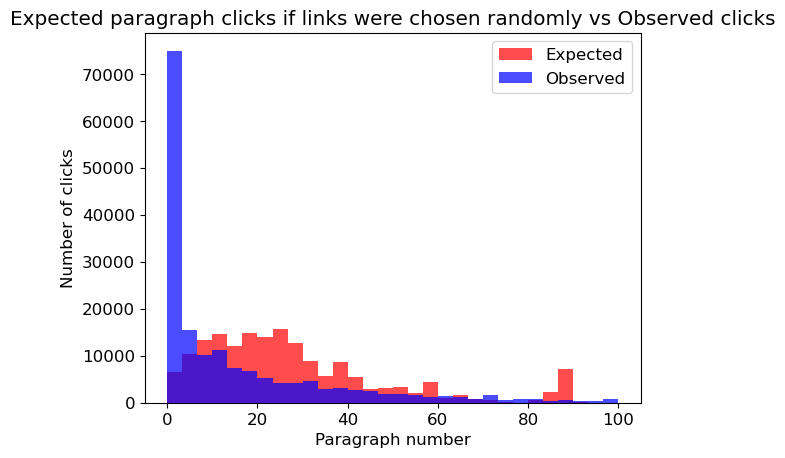

In [22]:
# Histogram comparing the average paragraphs of the
# links versus the paragraphs of the links chosen by the players

plt.hist(avg_pars, range=[0, 100], alpha=0.7, color="r", bins=30, label="Expected")
plt.xlabel("Paragraph number")
plt.ylabel("Number of clicks")
plt.title("Expected paragraph clicks if links were chosen randomly vs Observed clicks")
plt.hist(chosen_pars, range=[0, 100], alpha=0.7, color="b", bins=30, label="Observed")
plt.legend()
plt.show()


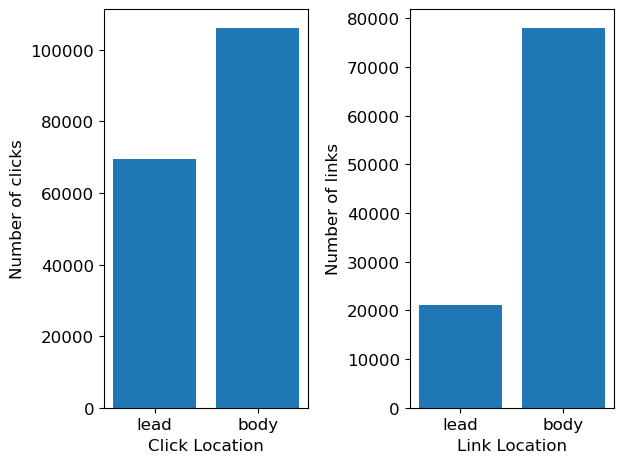

In [23]:
# Number of clicks in the lead section and the body section. We observe although
# just 20% of the total links are located in the lead section,
# they are chosen by the players more than 40% of the time.

label_enc = [0 if label == "lead" else 1 for label in chosen_labels]

body_clicks = sum(label_enc)
lead_clicks = len(label_enc) - body_clicks

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.set_ylabel("Number of clicks")
ax1.set_xlabel("Click Location")
ax1.bar(["lead", "body"], [lead_clicks, body_clicks])
ax2.bar(["lead", "body"], classes)
ax2.set_xlabel("Link Location")
ax2.set_ylabel("Number of links")

fig.tight_layout()
plt.show()


## Examination of link position per click
In the following section I examine how the network characteristics and the position of the link chosen change as the game progresses.

In [25]:
hubs_dict = dict(link_pos_df.groupby(by = 'page_name').agg('count').linked_page)
auth_dict = dict(link_pos_df.groupby(by = 'linked_page').agg('count').link_par)

In [35]:
hubs_per_turn = [0 for i in range(100)]
hub_counter = [0 for i in range(100)]
for path in paths:
    for i, article in enumerate(path):
        if i < len(path) - 1:
            source = article
            target = path[i + 1]
            if (source in hubs_dict.keys()):
                hubs_per_turn[i] += hubs_dict[source]
                hub_counter[i] += 1

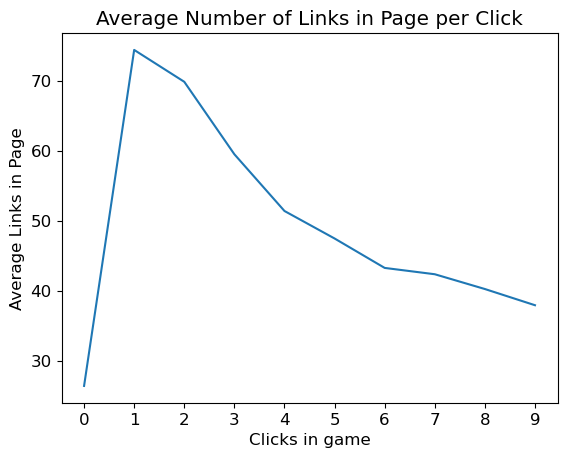

In [59]:
plt.plot(['{}'.format(i) for i in range(10)], np.array(hubs_per_turn[0:10])/np.array(hub_counter[0:10]));
plt.xlabel('Clicks in game'); #0 refers to the starting page
plt.ylabel('Average Links in Page');
plt.title('Average Number of Links in Page per Click');

In [37]:
auth_per_turn = [0 for i in range(80)]
auth_counter = [0 for i in range(80)]
for path in paths:
    for i, article in enumerate(path):
        if i < len(path):
            target = path[i]
            if (target in auth_dict.keys()):
                auth_per_turn[i] += auth_dict[target]
                auth_counter[i] += 1


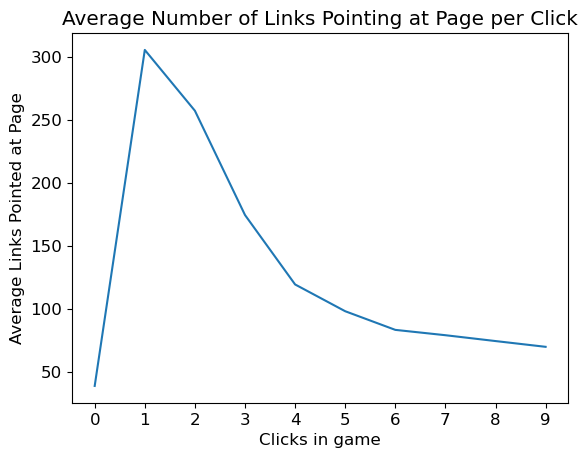

In [60]:
plt.plot(['{}'.format(i) for i in range(10)], np.array(auth_per_turn[0:10])/np.array(auth_counter[0:10]));
plt.xlabel('Clicks in game'); #0 refers to the starting page
plt.ylabel('Average Links Pointed at Page');
plt.title('Average Number of Links Pointing at Page per Click');

As we see from the above plots, the first click leads to a page with a very high indegree and outdegree and then progressively decreases as the game moves on. 

This is also noted in Robert West's paper: Players first click into a page of high importance that gives them access to many articles and then "zoom-in" to find more specialized articles related to the target article in order to succesfully complete the game.

In [46]:
#par_per_turn 

chosen_pars = [0 for i in range(500)]
chosen_labels = []
chosen_pars_counter = [0 for i in range(500)]
chosen_labels = {'lead' : [0 for i in range(80)], 'body' : [0 for i in range(80)]}
for path in paths:
    for i, article in enumerate(path):
        if i < len(path) - 1:
            source = article
            target = path[i + 1]
            if (target in page_pos_dict[source].keys()): 
                par_chosen = page_pos_dict[source][target][0]
                chosen_pars[i] += par_chosen
                chosen_pars_counter[i] += 1
                chosen_label = page_pos_dict[source][target][1]
                chosen_labels[chosen_label][i] += 1


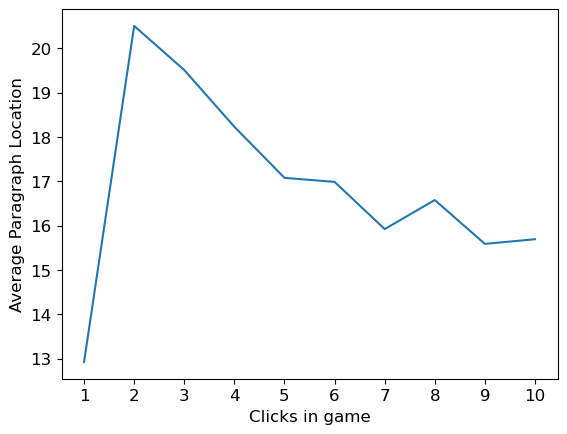

In [45]:
plt.plot(['{}'.format(i+1) for i in range(10)], np.array(chosen_pars[0:10])/np.array(chosen_pars_counter[0:10]));
plt.xlabel('Clicks in game');
plt.ylabel('Average Paragraph Location');

This is illuminating!!

The first click is located higher in the article on average. This occurs because the first introductory paragraphs contain articles of the form "is instance of" (can also be found in the literature) and hence lead to articles of higher importance and generality as seen in the plots before. 

On the second click the paragraph number increases drastically. This happens because the general "high importance" articles contain more paragraphs and also players are looking for more specialized articles which we suspect are located lower in the text.

After the second click the paragraph number decreases gradually which can be attributed to the lower total number of paragraphs these articles contain. 

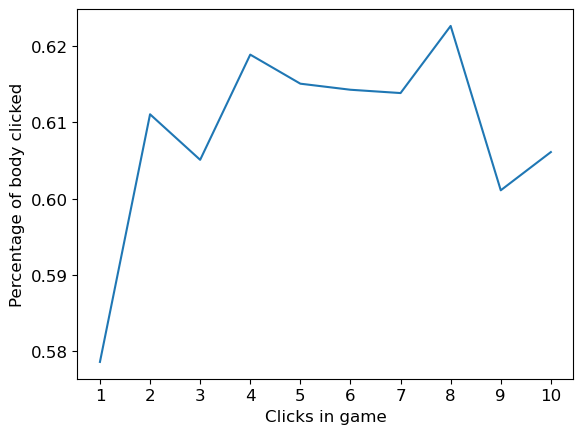

In [49]:
plt.plot(['{}'.format(i+1) for i in range(10)], np.array(chosen_labels['body'][0:10])/np.array(chosen_pars_counter[0:10]));
plt.xlabel('Clicks in game');
plt.ylabel('Percentage of body clicked');

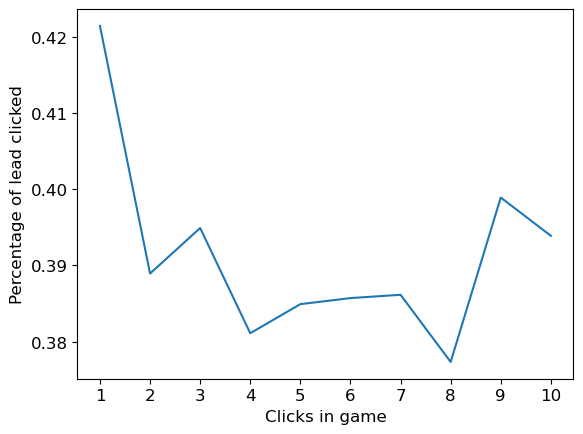

In [50]:
plt.plot(['{}'.format(i+1) for i in range(10)], np.array(chosen_labels['lead'][0:10])/np.array(chosen_pars_counter[0:10]));
plt.xlabel('Clicks in game');
plt.ylabel('Percentage of lead clicked');

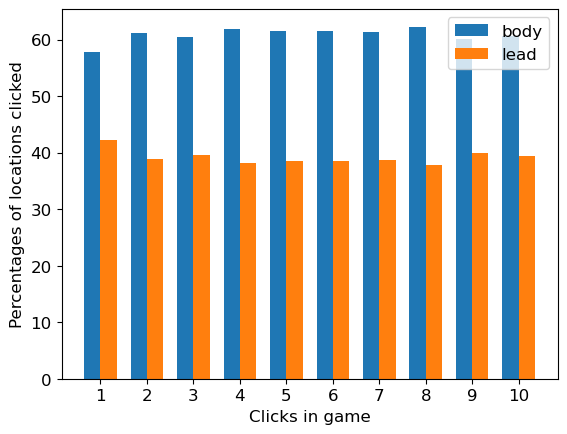

In [56]:
labels = ['{}'.format(i+1) for i in range(10)]
bodies = 100* np.array(chosen_labels['body'][0:10])/np.array(chosen_pars_counter[0:10])
leads =100* np.array(chosen_labels['lead'][0:10])/np.array(chosen_pars_counter[0:10])

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, bodies, width, label='body')
rects2 = ax.bar(x + width/2, leads, width, label='lead')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentages of locations clicked')
ax.set_xticks(x, labels)
ax.set_xlabel('Clicks in game');
ax.legend()

In examining the percentage of the lead or body sections chosen we see the same story. 

First click is more often chosen in the lead section and then we see the difference increasing as players are looking for more specialized articles.

In [ ]:
#TODO: Are Links in Lead hubs or authorities?
#TODO(MAYBE): Count words in documents?